In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Coolprop can be installed via pip. http://www.coolprop.org/coolprop/wrappers/Python/index.html
import CoolProp.CoolProp as CP
from CoolProp.HumidAirProp import HAPropsSI
from CoolProp.CoolProp import PropsSI

def exergy_water(T, P, T_0, P_0, twophase = 0):
    """
    This function calculates the flow exergy free energy of water using the coolprop database
    # T: Temperature in K
    # P: Partial pressure of Water in Pa
    # T_0: Dead state temperature
    # P_0: Dead state pressure    
    """  
    h_0 = PropsSI('H','T', T_0, 'P', P_0, 'Water')
    s_0 = PropsSI('S','T', T_0, 'P', P_0, 'Water')
    if twophase == 0:
            h = PropsSI('H','T', T, 'P', P, 'Water') - h_0
            s = PropsSI('S','T', T, 'P', P, 'Water') - s_0
    else:
            h = PropsSI('H','T',T,'Q',1,'Water') - h_0
            s = PropsSI('S','T', T, 'Q',1, 'Water') - s_0

    e_f = h - (T_0 * s)
    return e_f/1000

def get_pv2(T,rh): 
    """
    Description: This function returns the vapor pressure of water over ice or liquid, assuming the ice point is 273.15K.
    T: in K
    rh: [0,1]
    p_sat is calculated with the buck equation.
    pv is returned in Pa
    """
    T_c = T-273.15
    if T_c > 0:
        p_s_pa = np.exp(34.494 - 4924.99/(T_c + 237.1))
        p_s_pa = p_s_pa/np.power((T_c + 105), 1.57)
    #p_sat_kpa = 0.61121*np.exp((18.678 - T_c/234.5)*(T_c/(T_c + 257.14)))
    else:
        p_s_pa = np.exp(43.494 - 6545.8/(T_c + 278))
        p_s_pa = p_s_pa/np.power((T_c + 868), 2)
        #p_sat_kpa = 0.61115*np.exp((23.036 - T_c/333.7)*(T_c/(T_c + 279.82)))
    pv = p_s_pa*rh
    #pv = (1000*p_sat_kpa)*rh
    return pv

In [7]:
def get_zfactor(T, P):
    """
    Description: Calculates the compressibility factor of water based on a power series in pressure. 
    B is the 2nd virial coefficient from Keenan, J.H. (1969) Steam tables
    
    Params: 
        T: temperature in K
        P: pressure in Pa

    Return:
        Z: Compressibility factor (unitless)
    """
    B = 0.44687/T - (565.965/(T**2))*10**(100800/(34900 + T**2))
    B = B*10**(-5)
    Z = 1 + P*B
    return Z

def get_cp(T):
    """
    This function returns the specific heat capacity of water vapor
    Engineering ToolBox, (2005). Water Vapor - Specific Heat . [online] Available at: https://www.engineeringtoolbox.com/water-vapor-d_979.html [Accessed 01/07/2021].
    """
    return (9E-7)*T**2 - 0.0003*T + 1.8671


def get_gibbs(T, T0, Pv, P0):
    """
    Description: Calculates the gibbs free energy of a real gas relative to a specified dead state
    Params: 
        T: Desired temperature
        T0: Dead state temperature
        P: Desired vapor pressure 
        P0: Dead state vapor pressure 
    Return:
        dg: specific change in free energy [kJ/kg]
    """
    
    cp = get_cp(T)                        # kJ/kgK from 175 - 275K
    R = 0.415                             # Ideal gas constant kJ/kg K
    Z = get_zfactor(T, Pv)
    dT = T - T0
    
    dg = cp*(dT - T0*np.log(T/T0)) + Z*R*T0*np.log(Pv/P0)
    return dg


def get_gibbs_ice(T, T0):
    """
    Description: Calculates the gibbs free energy of ice (incompressible) relative to a specified dead state
    
    Params: 
        T: Desired temperature
        T0: Dead state temperature

    Return:
        dg: specific change in free energy [kJ/kg]
    """
    
    cp = 0.5*(get_cp(T) + get_cp(T0))     # kJ/kgK from 175 - 275K
    dT = T - T0
    dg = cp*(dT - T0*np.log(T/T0))
 
    return dg

In [8]:
# Define functions for calculating least work

def LW_single_comp(T_0,rh, T = 300):
    P_0 = get_pv2(T_0,rh)
    rec = [0.1, 0.05, 0.025]
    LW = []
    for r in rec:
        pv_feed = get_pv2(T_0, rh)
        pv_brine = pv_feed#*(1-r)
        pv_sat = get_pv2(T_0, rh = 1)

        feed_exergy = exergy_water(T_0, pv_feed, T_0, P_0,0)
        brine_exergy = exergy_water(T_0, pv_brine, T_0, P_0,0)
        saturated_exergy = exergy_water(T_0, pv_sat, T_0, P_0,0)
        #print(feed_exergy, brine_exergy, saturated_exergy)
        sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
        LW.append(sep)
    p = np.polyfit(rec,LW,2)
    sep = np.polyval(p,0)
    
    permeate_exergy = exergy_water(T, pv_sat, T_0, P_0,0)
    #print(permeate_exergy- saturated_exergy)
    heat = (1-T_0/T)*(permeate_exergy - saturated_exergy)
    if T_0>T:
        heat = heat*-1
    #print('single component', sep, heat, (1-T/T_0))
    return sep+heat

In [9]:
def LW_gibbswater(T_0, rh, T= 300):
    P_0 = get_pv2(T_0,rh)
    rec = [0.1, 0.05, 0.025]
    LW = []
    for r in rec:
        pv_feed = get_pv2(T_0, rh)
        pv_brine = pv_feed#*(1-r)
        pv_sat = get_pv2(T_0, rh = 1)

        feed_exergy = get_gibbs(T_0, T_0, pv_feed, P_0)
        brine_exergy = get_gibbs(T_0,T_0, pv_brine, P_0)
        saturated_exergy = get_gibbs(T_0,T_0, pv_sat, P_0)
        #print(feed_exergy, brine_exergy, saturated_exergy)
        sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
        LW.append(sep)
    p = np.polyfit(rec,LW,2)
    sep = np.polyval(p,0)
    
    pv_perm = get_pv2(T, 1)
    #print(T, pv_sat, T_0, pv_perm)
    permeate_exergy = get_gibbs(T, T_0, pv_perm, P_0)
    #print(permeate_exergy, saturated_exergy)
    heat = (permeate_exergy - saturated_exergy)*(1-T_0/T)

    #if T_0>T:
    #    heat = heat*-1
    #print('gibbs', sep, heat, (1-T/T_0))
    return sep + heat/100

In [22]:
def LW_ice(T):
    g_0 = get_gibbs_ice(T,T)
    g_p = get_gibbs_ice(300, T)
    return g_p - g_0


In [23]:
def gibbs_HA(T,P,rh, T_0):
    h = HAPropsSI('Hha','T', T, 'P', P, 'R',rh)
    s = HAPropsSI('Sha','T', T, 'P', P, 'R',rh)
    g = h-T_0*s
    return g

def gibbs_satv(T, T_0):
    h = PropsSI('H','T', T, 'Q',0,'Water')
    s = PropsSI('S','T', T, 'Q',0,'Water')
    g = h-T_0*s
    return g

def calcLW(T,P,rh,r = 0.1):
    W = HAPropsSI('W', 'T', T, 'P', P, 'R', rh)
    dw = []
    sep = []
    for i in np.arange(0, 3, 1):
        dw.append(r * W)
        W_reject = W * (1 - r)
        rh_reject = HAPropsSI('R', 'T', T, 'P', P, 'W', W_reject)
        G_p = gibbs_satv(T,T)
        G_f = gibbs_HA(T, P, rh,T)
        G_b = gibbs_HA(T, P, rh_reject,T)
        sep.append((G_p + G_b * (1 - dw[i]) / dw[i] - G_f / dw[i]) / 1000)
        r = r / 2
    z = np.polyfit(dw, sep, 2)
    f = np.poly1d(z)
    min_sep = f(0)
    return min_sep

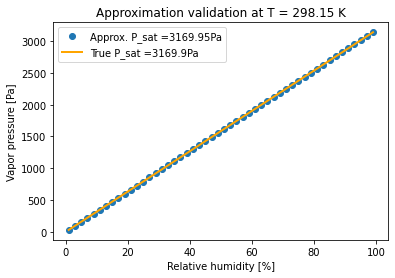

In [35]:
## Validate the vapor pressure correlation

rh_amb = np.linspace(0.01, 0.99, 50)
pv_test = get_pv2(298.15, rh_amb)
pv_sat_test = get_pv2(298.15,1)
pv_true = rh_amb*3169.9
fig2, ax2 = plt.subplots()
ax2.set_title('Approximation validation at T = 298.15 K')
ax2.set_ylabel('Vapor pressure [Pa]')
ax2.set_xlabel('Relative humidity [%]')

ax2.plot(100*rh_amb, pv_test, 'o',lw = 1, label = 'Approx. P_sat =' + str(round(pv_sat_test,2)) + 'Pa')
ax2.plot(100*rh_amb, pv_true, 'orange',lw = 2, label = 'True P_sat =' + str(3169.9) + 'Pa')
ax2.legend();
fig2.savefig('approx_val.svg')

In [39]:
# Validate compressibility against values presented in Wexler, 1977
# Data is copied manually from the manuscript table
temp = np.asarray([0.01, 0, -10, -20, -30, -40, -60, -80, -100]) + 273.15
Z_keyes = np.asarray([0.999624, 0.999624, 0.999907,  0.999958, 0.999982, 0.999993, 0.99999, 1.0, 1.0])
z = np.zeros_like(temp)
for i, T in enumerate(temp):
    p = get_pv2(T, 1)
    z[i] = get_zfactor(T, p)
err = Z_keyes - z
err_percent = 100*np.divide(err, Z_keyes)
print('Maximum error in Z-factor formula: ', round(np.max(err_percent),4), '%')

Maximum error in Z-factor formula:  0.01 %


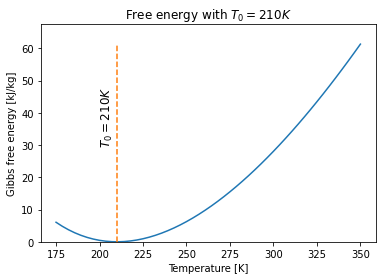

In [29]:
# Validate the gibbs free energy calculation wrt. an arbitrary dead state

T0 = 210
Pv = 0.5
P = 0.5
temp = np.linspace(175, 350)
gibbs = []
for T in temp:
    g = get_gibbs(T, T0, Pv, P)
    gibbs = np.append(gibbs, g)

gibbs = np.asarray(gibbs)
fig, ax = plt.subplots()
ax.plot(temp, gibbs)
ax.plot(np.linspace(T0,T0), np.linspace(0, np.max(gibbs)), '--')
ax.text(200, 0.5*max(gibbs), r'$T_0 = 210K$', fontsize=12, rotation = 90)
ax.set_ylim([0,1.1*max(gibbs)])
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Gibbs free energy [kJ/kg]')
ax.set_title('Free energy with $T_0 = 210K$')
plt.show()

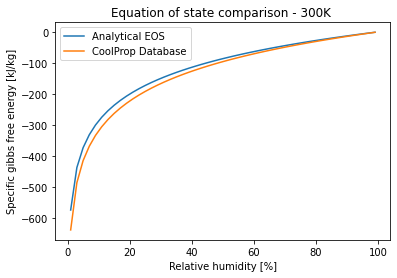

In [24]:
# Validate the analytical equation of state against a database

T0 = 300
T = 300
humd = np.linspace(0.01, 0.99)
ef = np.zeros_like(humd)
g = np.zeros_like(humd)
for i, rh in enumerate(humd):
    pv = get_pv2(T, rh)
    pv0 = get_pv2(T0, 1)
    ef[i] = exergy_water(T, pv, T0, pv0)
    g[i] = get_gibbs(T, T0, pv, pv0)

fig, ax = plt.subplots()
ax.plot(100*humd, g, label = 'Analytical EOS')
ax.plot(100*humd, ef, label = 'CoolProp Database')
ax.set_title('Equation of state comparison - 300K ')
ax.set_xlabel('Relative humidity [%]')
ax.set_ylabel('Specific gibbs free energy [kJ/kg]')
plt.legend();


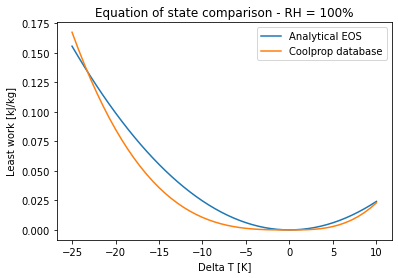

In [25]:
# Validate the analytical equation of state against a database

temp = np.linspace(275,310,50)
humd = np.linspace(0.01, 1, 50)

trials = 50
LW_test2 = np.zeros(trials)
LW_test3 = np.zeros(trials)
for i, T in enumerate(temp):
    LW_test2[i] = LW_single_comp(T, rh= 1)
    LW_test3[i] = LW_gibbswater(T, rh= 1)

fig4,ax4 = plt.subplots()
#print(LW_test2)
dT = temp - 300
ax4.plot(dT, LW_test3, label = 'Analytical EOS')
ax4.plot(dT, LW_test2, label = 'Coolprop database')
ax4.set_xlabel('Delta T [K]')
ax4.set_ylabel('Least work [kJ/kg]')
ax4.set_title('Equation of state comparison - RH = 100%')
plt.legend();
fig4.savefig('EOS_validation2.svg')
plt.show()


In [26]:
# Run this to get the minimum least work with the single component approximation

T = 300
P = 10100

T_0 = 300

r = 0.3
T_amb = T_0


LW = []
rec = [0.1, 0.05, 0.025]
min_LW = []
for rh_amb in np.linspace(0.01,0.99,100):
        P_0 = get_pv2(T_0,rh_amb)
        for r in rec:
                pv_feed = get_pv2(T_amb,rh_amb)
                pv_brine = pv_feed#*(1-r)
                pv_sat = get_pv2(T_amb, rh =1)# np.linspace(1,1))

                feed_exergy = exergy_water(T_0, pv_feed, T_0, P_0,0)
                brine_exergy = exergy_water(T_0, pv_brine, T_0, P_0,0)
                saturated_exergy = exergy_water(T, pv_sat, T_0, P_0,1)

                #perm_exergy = exergy_water(T, P, T_0, P_0, 1)
                sep = saturated_exergy + (1-r)*brine_exergy/r - feed_exergy/r
                LW.append(sep)
        
        p = np.polyfit(rec,LW,2)
        LW = []
        min_LW.append(round(np.polyval(p,0),2))

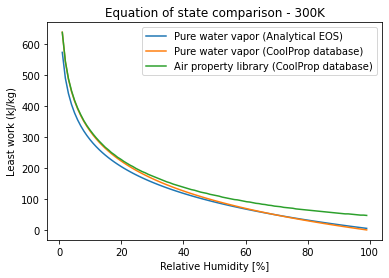

In [27]:
# Compare various equations of state for water harvesting energy requirements 

T = 300
LW_CP = []
LW_GF = []
for rh_amb in np.linspace(0.01,0.95,100):
    temp_lw_calc = calcLW(T,P,rh = rh_amb)
    LW_CP.append(round(temp_lw_calc))
    temporary = LW_gibbswater(300, rh_amb, 300)
    LW_GF.append(temporary)

rh_amb = np.linspace(0.01,0.99,100)
fig, ax = plt.subplots()
ax.set_title('Equation of state comparison - ' + str(round(T)) + 'K')
ax.set_ylabel('Least work (kJ/kg)')
ax.set_xlabel('Relative Humidity [%]')
ax.plot(rh_amb*100, LW_GF, label = 'Pure water vapor (Analytical EOS)')
ax.plot(rh_amb*100, min_LW, label = 'Pure water vapor (CoolProp database)')
ax.plot(rh_amb*100, LW_CP, label = 'Air property library (CoolProp database)')
ax.legend();


In [30]:
## Parametrically sweep conditions and calculate least work with the single component and analytical EOS 

humd = np.linspace(0.01,0.99,100)
temp = np.linspace(290,310,100)
LW_GW_check = np.zeros((len(humd), len(temp)))
LW_SC = np.zeros((len(humd), len(temp)))

for i,rh in enumerate(humd):
    for j,T in enumerate(temp):
        singlecomp_lw_calc = LW_single_comp(T, rh= rh)
        analytical_lw_calc = LW_gibbswater(T, rh)
        LW_SC[i][j] = singlecomp_lw_calc
        LW_GW_check[i][j] = analytical_lw_calc

In [31]:
residual = LW_GW_check - LW_SC
percent_error = 100*np.divide(residual,LW_GW_check)

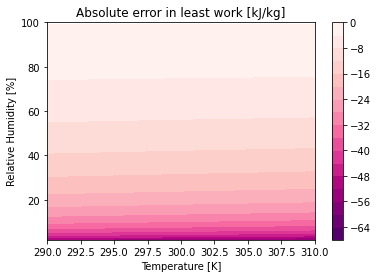

In [32]:
## Plot absolute error 
fig2, ax2 = plt.subplots()
ax2.set_title('Absolute error in least work [kJ/kg]')
ax2.set_ylabel('Relative Humidity [%]')
ax2.set_xlabel('Temperature [K]')
ax2.set_xlim([290,310])
ax2.set_ylim([2,100])
cs = ax2.contourf(temp, 100*humd, residual, 20, cmap="RdPu_r")
cbar = fig2.colorbar(cs)
plt.show()
fig2.savefig('air_water_vaporcomp.svg')

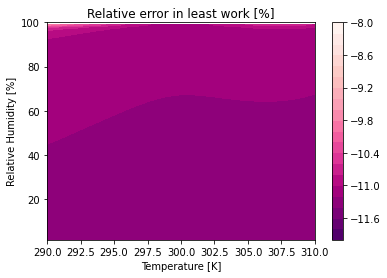

In [33]:
## Plot relative error = absolute / analytical LW value

fig2, ax2 = plt.subplots()
ax2.set_title('Relative error in least work [%]')
ax2.set_ylabel('Relative Humidity [%]')
ax2.set_xlabel('Temperature [K]')
ax2.set_xlim([290,310])
ax2.set_ylim([1.5,100])
length = np.linspace(-12,-8, 21)
cs = ax2.contourf(temp, 100*humd, percent_error, length, cmap="RdPu_r")
cbar = fig2.colorbar(cs)
plt.show()
fig2.savefig('air_water_res.svg')

In [34]:
# Extend the range of calculation with the analytical EOS

humd = np.linspace(0.01,0.99,100)
temp = np.linspace(180,420,100)
LW_GW = np.zeros((len(humd), len(temp)))


for i,rh in enumerate(humd):
    for j,T in enumerate(temp):
        analytical_lw_calc = LW_gibbswater(T, rh= rh)
        LW_GW[i][j] = round(analytical_lw_calc,2)

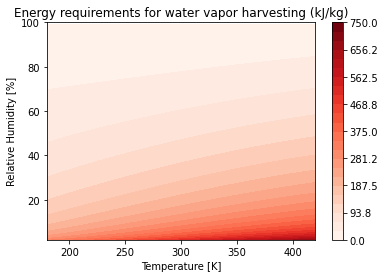

In [35]:
## Plot it 
fig, ax = plt.subplots()
ax.set_title('Energy requirements for water vapor harvesting (kJ/kg)')
ax.set_ylabel('Relative Humidity [%]')
ax.set_xlabel('Temperature [K]')
ax.set_xlim([180,420])
ax.set_ylim([1.9,100])
L = np.linspace(0, 750, 25)
cs = ax.contourf(temp, 100*humd, LW_GW, L, cmap="Reds")
cbar = fig.colorbar(cs)
plt.show()

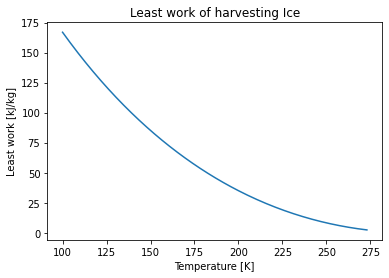

In [38]:
# Also do the same thing for Ice 
T = np.linspace(100, 273, 200)
ice_work = LW_ice(T)
fig, ax = plt.subplots()
ax.plot(T, ice_work)
ax.set_title('Least work of harvesting Ice')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Least work [kJ/kg]');